# 画像生成 AI 入門: Python による拡散モデルの理論と実践
## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 28. LoRA

LoRA [[Hu+ ICLR'22]](https://arxiv.org/abs/2106.09685) を用いて元々の Stable Diffusion の重みはそのままに、省メモリを達成しながらさまざまなスタイルを学習可能にしていきます。以下 [🤗 Low-Rank Adaptation of Large Language Models (LoRA)](https://huggingface.co/docs/diffusers/training/lora) を参考に動作を追っていきます。

huggingface/diffusers では 2023/07/25 現在、LoRA は [`UNet2DConditionalModel`](https://huggingface.co/docs/diffusers/api/models/unet2d-cond) の attention 層のみに対応しています。また、一部 DreamBooth の text encoder を LoRA で微調整することもサポートしています。DreamBooth の text encoder を微調整すると一般的に良い結果が得られますが、計算量が増える可能性があります。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [1]:
!nvidia-smi

Sat Jul 29 02:49:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### huggingface/diffusers からレポジトリを clone してインストール

今回は [huggingface/diffusers](https://github.com/huggingface/diffusers) の example に用意されている以下 2 つの python スクリプトを使用します:
- [`examples/text_to_image/train_text_to_image_lora.py`](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py)
- [`examples/dreambooth/train_dreambooth_lora.py`](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora.py)

これらのスクリプトを使用するために、huggingface/diffusers からレポジトリを clone します。その後 clone したレポジトリのディレクトリに移動し、ベースとなる依存ライブラリを pip でインストールします。

In [2]:
!git clone https://github.com/huggingface/diffusers.git
%cd /content/diffusers
!pip install .

Cloning into 'diffusers'...
remote: Enumerating objects: 32512, done.
remote: Total 32512 (delta 0), reused 0 (delta 0), pack-reused 32512
Receiving objects: 100% (32512/32512), 20.83 MiB | 22.96 MiB/s, done.
Resolving deltas: 100% (23967/23967), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.5 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.20.0.dev0-py3-none-any.whl size=1321056 sha256=75554b5a2ce81961996250c8c01d1f9c2db76ea1310abb74db240027c0be84e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-pn2f90cg/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers


準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [3]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Text-to-Image における LoRA チューニング

LoRA でモデルの微調整は LoRA チューニングと呼ぶことが多く、従来のモデル全体の微調整はフルファインチューニングと呼ばれています。

何十億ものパラメータを持つ Stable Diffusion のような拡散モデルのフルファインチューニングは時間もコストも掛かります。LoRA チューニングを使用すると拡散モデルの微調整が遥かに簡単に、かつ高速になります。LoRA は効果的な注意機構 (attention mechanism) や 8-bit optimizer などの GPU RAM の省メモリ技術に頼ることなく、Colab GPU 上のわずか 11 GB の GPU RAM で動作します。

### 依存ライブラリのインストール

本セクションでは [`examples/text_to_image/train_text_to_image_lora.py`](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py) を使用して text-to-image モデルの LoRA チューニングを試します。ここでは、LoRA チューニングが可能なスクリプトで使用するライブラリを、対応する [`examples/text_to_image/requirements.txt`](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/requirements.txt) からインストールします。

In [4]:
%cd /content/diffusers/examples/text_to_image
!pip install -r requirements.txt

/content/diffusers/examples/text_to_image
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


今回は [Pokémon BLIP captions](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions) を用いて `stable-diffusion-v1-5` を微調整して、自分だけのポケモンを生成してみましょう。

LoRA チューニングが可能なスクリプトを実行する際に使用する環境変数を以下のように準備しておきます:
- `MODEL_NAME` には今回使用する `stable-diffusion-v1-5` を設定
- `DATASET_NAME` には今回学習させる `lambdalabs/pokemon-blip-captions` を設定
- `OUTPUT_DIR` には学習結果をどこに保存するかを設定

In [5]:
%env MODEL_NAME=runwayml/stable-diffusion-v1-5
%env DATASET_NAME=lambdalabs/pokemon-blip-captions
%env OUTPUT_DIR=/sddata/finetune/lora/pokemon

env: MODEL_NAME=runwayml/stable-diffusion-v1-5
env: DATASET_NAME=lambdalabs/pokemon-blip-captions
env: OUTPUT_DIR=/sddata/finetune/lora/pokemon


### LoRA チューニングの実施

これで LoRA チューニングを開始する準備ができました。スクリプトには以下のように複数のオプションを指定することが出来ますが、いくつか注意すべきオプションがあります:
- `--max_train_steps`: 学習回数を指定するオプションです。デフォルトでは 15,000 に設定されていますが、Colab で実行すると約 6 時間程度訓練に時間がかかります。今回の実習では動作確認のために 10 を設定します
- `--learing_rate`: LoRA では比較的高めの学習率を設定可能です。デフォルトでは `1e-4` が設定されていますが、通常の微調整では `1e-5 ~ 1e-6` を使うことが多いでしょう

In [6]:
!accelerate launch --mixed_precision="fp16" train_text_to_image_lora.py \
  --pretrained_model_name_or_path="${MODEL_NAME}" \
  --dataset_name="${DATASET_NAME}" \
  --dataloader_num_workers=8 \
  --resolution=512 \
  --center_crop \
  --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=10 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --output_dir="${OUTPUT_DIR}" \
  --checkpointing_steps=500 \
  --validation_prompt="A pokemon with blue eyes." \
  --seed=1337

2023-07-29 02:57:29.853137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-07-29 02:57:35.909420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
07/29/2023 02:57:38 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'clip_sample_range', 'thresholding', 'variance_type', 'sample_max_value', 'prediction_type', 'dynamic_thresholding_ratio', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
{'scaling_factor', 'force_upcast'} wa

### LoRA チューニング結果を元にした推論

上記で学習した結果を元に、`StableDiffusionPipeline` でベースとなるモデル (`runwayml/stable-diffusion-v1-5`) を読み込み、`DPMSolverMultistepScheduler` で推論できるように準備します。

In [7]:
import os
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

model_base = os.environ["MODEL_NAME"]

pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


ベースモデルの重みの上に微調整した LoRA モジュールを `unet` の `load_attn_procs` 関数で読み込み、パイプラインを GPU へ移動して推論を高速化します。

In [8]:
lora_model_path = os.environ["OUTPUT_DIR"]

pipe.unet.load_attn_procs(lora_model_path)
pipe = pipe.to("cuda")

パイプラインを用いた推論時に、以下のように `cross_attention_kwargs` オプションで `scale` パラメータを設定することが可能です。このパラメータにより、LoRA モジュールの影響度合いを制御することが可能です。

ここで、scale 値が 0 のときは LoRA モジュールを使用せずオリジナルのベースモデルの重みのみを使用するのと同じです。逆に scale 値が 1 のときは LoRA モジュールのみを使用することを意味します。scale 値は 0 ~ 1 の間で 2 つの重みを補完します。

時間の関係上、上記の LoRA チューニングでは十分な学習ができていないためここでは画像生成結果をお見しておりません。ただ、以下のようにしてコードを実行することで LoRA チューニングによって獲得された自分だけのポケモンの画像が生成できるようになります。

以下は、LoRA モジュールの重みの半分と、ベースモデルの重みの半分を使用する例です:

```python
pipe(
    prompt="A pokemon with blue eyes.",
    num_inference_steps=25,
    guidance_scale=7.5,
    cross_attention_kwargs={"scale": 0.5},
).images[0]
```

以下は、LoRA モジュールによる重みをすべて使用する例です:

```python
pipe(
    prompt="A pokemon with blue eyes.",
    num_inference_steps=25,
    guidance_scale=7.5,
).images[0]
```

以下は上記で LoRA チューニングに使用した [lambdalabs/pokemon-blip-captions](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions) を十分に学習させた [`sayakpaul/sd-model-finetuned-lora-t4`](https://huggingface.co/sayakpaul/sd-model-finetuned-lora-t4) による画像生成例です。

LoRA モジュールのモデル ID から `RepoCard.load` を通じてモデル情報を読み込み、ベースモデルの情報を取得します。その後取得したベースモデルを読み込み、`load_attn_procs` で LoRA モジュールも読み込む流れになっています。あとはこれまでのパイプライン同様の生成の流れを踏みます。

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

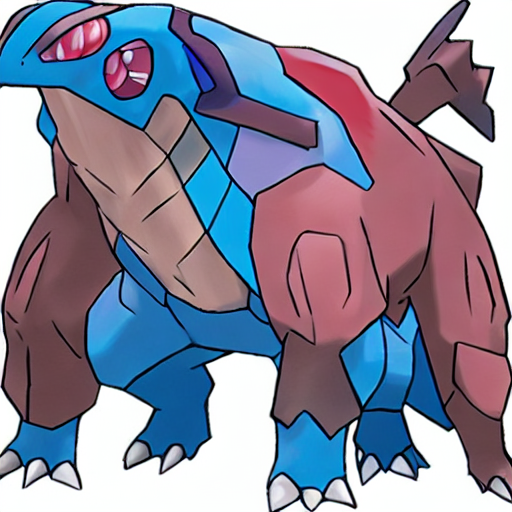

In [9]:
from huggingface_hub.repocard import RepoCard

lora_model_id = "sayakpaul/sd-model-finetuned-lora-t4"
card = RepoCard.load(lora_model_id)
base_model_id = card.data.to_dict()["base_model"]

pipe = StableDiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)

pipe.unet.load_attn_procs(lora_model_id)
pipe = pipe.to("cuda")

generator = torch.Generator().manual_seed(42)

pipe(
    prompt="A pokemon with blue eyes.",
    num_inference_steps=25,
    guidance_scale=7.5,
    generator=generator,
).images[0]

## DreamBooth における LoRA チューニング

DreamBooth [[Ruiz+ CVPR'23]](https://arxiv.org/abs/2208.12242) は Stable Diffusion のような Text2Image モデルを個人の趣向に合わせてパーソナライズするためのファインチューニング手法です。この手法は被写体の画像数枚から、異なるコンテキストにおける被写体の写実的な画像を生成可能な技術になっています。

しかしながら DreamBooth はハイパーパラメータに非常に敏感で、過学習しやすい傾向にあります。考慮すべき重要なハイパーパラメータは学習時間（学習率・学習回数）、推論時間（拡散過程のステップ数・ノイズスケジューラの種類）に影響するものがあります。

### 依存ライブラリのインストール

本セクションでは [`examples/dreambooth/train_dreambooth_lora.py`](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora.py) を使用して dreambooth モデルの LoRA チューニングを試します。ここでは、dreambooth で LoRA チューニングが可能なスクリプトで使用するライブラリを、対応する [`examples/dreambooth/requirements.txt`](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/requirements.txt)
 からインストールします。

In [10]:
%cd /content/diffusers/examples/dreambooth
!pip install -r requirements.txt
!pip install bitsandbytes # 8-bit Adam optimizer を使用するため

/content/diffusers/examples/dreambooth
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 12.4 MB/s eta 0:00:00


今回は DreamBooth と LoRA を使って [コーギー🐶の画像](https://huggingface.co/datasets/diffusers/dog-example) を用いて `stable-diffusion-v1-5` を微調整してみましょう。

LoRA チューニングが可能なスクリプトを実行する際に使用する環境変数を以下のように準備しておきます:
- `MODEL_NAME` には今回使用する `stable-diffusion-v1-5` を設定
- `INSTANCE_DIR` には今回学習させるコーギーの画像が保存されているディレクトリを設定
- `OUTPUT_DIR` には学習結果をどこに保存するかを設定

In [11]:
%env MODEL_NAME=runwayml/stable-diffusion-v1-5
%env INSTANCE_DIR=/sddata/instance-dir/
%env OUTPUT_DIR=/sddata/output-dir/

env: MODEL_NAME=runwayml/stable-diffusion-v1-5
env: INSTANCE_DIR=/sddata/instance-dir/
env: OUTPUT_DIR=/sddata/output-dir/


以下を実行して `INSTANCE_DIR` に設定した場所に [`diffusers/dog-example`](https://huggingface.co/datasets/diffusers/dog-example) から画像をダウンロードします。

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

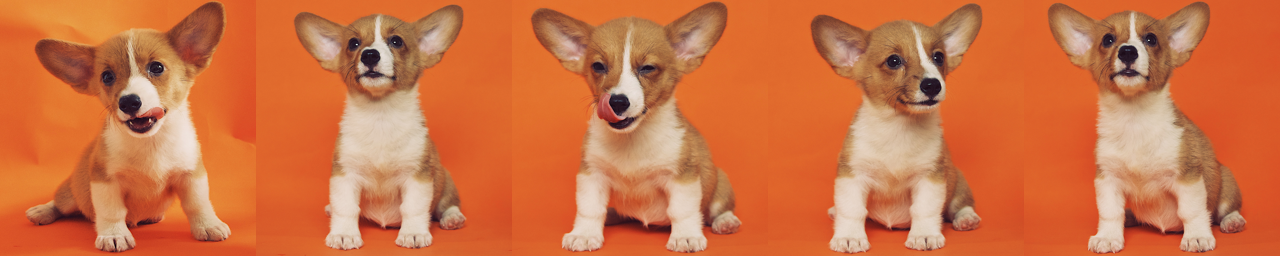

In [12]:
from diffusers.utils import load_image
from huggingface_hub import snapshot_download

instance_dir = os.environ["INSTANCE_DIR"]

snapshot_download(
    "diffusers/dog-example",
    local_dir=instance_dir,
    repo_type="dataset",
    ignore_patterns=".gitattributes",
)

jpg_files = os.listdir(instance_dir)
dog_examples = [
    load_image(os.path.join(instance_dir, jpg_file)).resize((256, 256))
    for jpg_file in jpg_files
]

image_grid(dog_examples, rows=1, cols=len(dog_examples))

### LoRA チューニングの実施

これで LoRA チューニングを開始する準備ができました。スクリプトには以下のように複数のオプションを指定することが出来ますが、いくつか注意すべきオプションがあります:
- `--max_train_steps`: 学習回数を指定するオプションです。デフォルトでは 500 に設定されていますが、Colab で実行すると約 6 時間程度訓練に時間がかかります。今回の実習では動作確認のために 10 を設定します
- `--checkpointing_steps`: 学習途中のパラメータを保存するタイミングを指定するオプションです。デフォルトは 100 に設定されていますが、上記の `--max_train_steps` に合わせて 5 に変更しました
- `--learing_rate`: LoRA では比較的高めの学習率を設定可能です。デフォルトでは `1e-4` が設定されていますが、通常の微調整では `1e-5 ~ 1e-6` を使うことが多いでしょう

In [13]:
!accelerate launch --mixed_precision="fp16" train_dreambooth_lora.py \
  --pretrained_model_name_or_path="${MODEL_NAME}"  \
  --instance_data_dir="${INSTANCE_DIR}" \
  --output_dir="${OUTPUT_DIR}" \
  --instance_prompt="a photo of sks dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=5 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=10 \
  --seed="0" \
  --use_8bit_adam

2023-07-29 03:16:10.102240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-07-29 03:16:18.325093: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
07/29/2023 03:16:22 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'clip_sample_range', 'timestep_spacing', 'prediction_type', 'thresholding', 'dynamic_thresholdi

CLIP の text encoder を LoRA でファインチューニングすることも可能です。殆どの場合、計算量を少し増やすだけで、よりよい結果をもたらします。LoRA で text encoder をファインチューニングするには、`train_dream_lora.py` を実行する際に、`--train_text_encoder` を指定してください。

### LoRA チューニング結果を元にした推論

Text-to-Image における LoRA チューニングでも説明しましたが、DreamBooth との組み合わせでも同様に`StableDiffusionPipeline` でベースモデルを読み込み、推論パイプラインを構成します。

ベースモデルの重みの上に、ファインチューニングした DreamBooth モデルの LoRA モジュールを読み込み、パイプラインを GPU に移動させて推論を高速化します。`scale` 値でベースモデルと LoRA モジュールの利用度合いを調整できたことを思い出してください。

```python
model_base = os.environ["MODEL_NAME"]
lora_model_path = os.environ["OUTPUT_DIR"]

pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)

pipe.unet.load_attn_procs(lora_model_path)
pipe = pipe.to("cuda")

image = pipe(
    "A picture of a sks dog in a bucket.",
    num_inference_steps=25,
    guidance_scale=7.5,
    cross_attention_kwargs={"scale": 0.5},
).images[0]
```

時間の関係上、上記 DreamBooth と LoRA チューニングの組み合わせでは十分な学習ができていないためここでは画像生成結果をお見しておりません。

ただ、以下のようにしてコードを実行することで DreamBooth と LoRA チューニングによって獲得されたコーギーを合成したような画像が生成可能です。

以下は上記で LoRA チューニングに使用した [diffusers/dog-example](https://huggingface.co/datasets/diffusers/dog-example) を十分に LoRA DreamBooth で学習させた [`patrickvonplaten/lora_dreambooth_dog_example`](https://huggingface.co/patrickvonplaten/lora_dreambooth_dog_example) による画像生成例です。

LoRA モジュールの読み込みには、上記で使用した `load_attn_procs()` よりも、`load_lora_weights()` の使用が好ましいようです（[公式ドキュメントより](https://huggingface.co/docs/diffusers/v0.18.2/en/training/lora#text-to-image-inference)）。これは `load_lora_weights()` が以下の状況に対応できるからです:
- U-Net や text encoder で別々の識別子を持たない LoRA モジュール（今回使用した [`patrickvonplaten/lora_dreambooth_dog_example`](https://huggingface.co/patrickvonplaten/lora_dreambooth_dog_example) 含めて）の場合
- U-Net や text encoder で別々の識別子を持つ LoRA モジュール（[`sayakpaul/dreambooth`](https://huggingface.co/sayakpaul/dreambooth) など）

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


/usr/local/lib/python3.10/dist-packages/diffusers/loaders.py:1223: UserWarning: You have saved the LoRA weights using the old format. To convert the old LoRA weights to the new format, you can first load them in a dictionary and then create a new dictionary like the following: `new_state_dict = {f'unet'.{module_name}: params for module_name, params in old_state_dict.items()}`.
  warnings.warn(warn_message)


  0%|          | 0/25 [00:00<?, ?it/s]

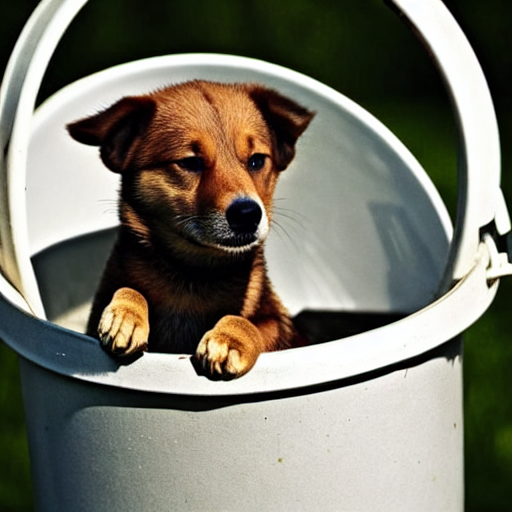

In [14]:
lora_model_id = "patrickvonplaten/lora_dreambooth_dog_example"
card = RepoCard.load(lora_model_id)
base_model_id = card.data.to_dict()["base_model"]

pipe = StableDiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)
pipe.load_lora_weights(lora_model_id)

pipe = pipe.to("cuda")

generator = torch.Generator().manual_seed(2)

pipe(
    "A picture of a sks dog in a bucket.",
    num_inference_steps=25,
    guidance_scale=7.5,
    generator=generator,
    cross_attention_kwargs={"scale": 0.5},
).images[0]